# Name Collection

In [ ]:
!wget https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/wiki_names.txt

In [ ]:
!wget https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/celebs.txt

In [ ]:
#%pip install scikit-learn diffusers pillow torch umap-learn

In [1]:
from pathlib import Path
from diffusers import StableDiffusionPipeline
import torch
import diffusers
import time
import torch
import matplotlib.pyplot as plt
import PIL
import numpy as np

In [9]:
#with Path('wiki_names.txt').open() as f:
with Path('celebs.txt').open() as f:
    wiki_names = f.read().split('\n')

len(wiki_names) # 1109

first_names = [n for n in set([name.split(' ')[0] for name in wiki_names]) if '.' not in n]
last_names = [n for n in set([name.split(' ')[-1] for name in wiki_names]) if '.' not in n]

len(first_names), len(last_names)

(107, 110)

# Image Generation

In [12]:
model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(
                model_id,
                revision="fp16",
                #torch_dtype=torch.float16,
                #use_auth_token=True
            ).to('cuda')

# https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/scheduler/scheduler_config.json
true, false, null = True, False, None
pipe.scheduler = diffusers.EulerDiscreteScheduler(
    **{
      "beta_end": 0.012,
      "beta_schedule": "scaled_linear",
      "beta_start": 0.00085,
      "interpolation_type": "linear",
      "num_train_timesteps": 1000,
      "prediction_type": "epsilon",
      "steps_offset": 1,
      "timestep_spacing": "leading",
      "trained_betas": null,
      "use_karras_sigmas": false
    }
)

# disable safety checker

#pipe.requires_safety_checker=False
def passthrough(images, *args, **kargs):
    return images, [False for _ in images]
pipe.safety_checker = passthrough

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/dmarx/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
# 1. loop over names
# 2. create folder for names
# 3. generate images, save to folder
# 4. compute CLIP/DINO image embeddings, save to folder

# ---

# let's start with 10 names and prototype this procedure generally.
# an important hyper parameter to start with will be the number of images per name.
# let's start by generating an unnecessary number of images for this first group, say 20-100.
# then use these to compute our diversity measures, and calibrate how many images we need by how many images it generally takes to get this measure to converge.


In [17]:
# RUN THIS CELL TO GENERATE IMAGES

names = first_names

kwargs = dict(
    num_inference_steps=25,
    num_images_per_prompt=8
)

root = Path("images")

#images_per_prompt = 24 #40
images_per_prompt = 64

for name in names:
    print(name)
    prompt = f"a photo of {name}, portrait photography, full color, face full frame"
    prompt = prompt.lower().strip()
    
    prompt_clean = prompt.replace(',','')
    outdir = root / prompt_clean.replace(' ','_')  
    outdir.mkdir(parents=True, exist_ok=True)
    while len(list(outdir.glob('*.png'))) < images_per_prompt:
        outv = pipe(prompt, **kwargs)
        #if any(outv.nsfw_content_detected):
        #    #continue
        #    break

        for idx,im in enumerate(outv.images):
            # would prefer to name images by seed, but hf is makes it hard.
            fname = outdir / f"{int(time.time())}_{idx}.png" 
            im.save(fname)


Rihanna
Bolo
Ben
Oprah
Judge
Julia
Shaquille
Keanu
Cher
Devon
Mel
BD
Lionel
Ed


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

LeBron


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Parminder


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

David
Konnie


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Beyoncé
Steven


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Rick


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Pat


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Amita


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Michael
Kylie
Celine


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Archie


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Yuvraj


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Dalip
Angelina


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Sarah


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Adele


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Davood


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Donnie


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Lady


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Nina
Dave


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Jerry
Rae


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Kunal


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Neymar
Brandon


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Johnny
Sung


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Tyler


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Dwayne
Rush
Kobe
Will


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Billy


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Tom


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Paul
Naga


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Hailee
Brad
Robert


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Simon


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Cristiano


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Amol


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Justin
Kanye
Robin


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Himesh


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Elon


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Brian


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Kevin


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Dennis


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

James


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Dante


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Anne


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Iko


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Bruce
Yayan


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Elton
Lou
Anupam
Katy


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Drake


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Dev


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Norah


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Lilly
Ellen


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Jennifer


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Leonardo
Mariah


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Heung


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Mindy
Howard
Meera


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Tony


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Taylor


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Sandra
Ernie


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Madonna


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Kelly


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Britney
Tina


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Tatyana


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Roger


In [ ]:
# let's generate a shit load of images 
# for a few high-bias names as a calibration control
# for sensitivity analysis.

high_bias_names = [
    "oprah",
    "keanu",
    "cher",
    "beyoncé",
    "shaquille",
    "rihanna",
    "anupam",
]

images_per_prompt = 200


for name in high_bias_names:
    print(name)
    prompt = f"a photo of {name}, portrait photography, full color, face full frame"
    prompt = prompt.lower().strip()
    
    prompt_clean = prompt.replace(',','')
    outdir = root / prompt_clean.replace(' ','_')  
    outdir.mkdir(parents=True, exist_ok=True)
    while len(list(outdir.glob('*.png'))) < images_per_prompt:
        outv = pipe(prompt, **kwargs)
        #if any(outv.nsfw_content_detected):
        #    #continue
        #    break

        for idx,im in enumerate(outv.images):
            # would prefer to name images by seed, but hf is makes it hard.
            fname = outdir / f"{int(time.time())}_{idx}.png" 
            im.save(fname)

# Image embedding

## DINO

In [50]:
#del dinov2_vits14
#del pipe
import gc
gc.collect()
torch.cuda.empty_cache()

In [51]:
#dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
#dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
#dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

#backbone_model = dinov2_vits14
#emb_suffix = ".dinov2_cls.embed"


backbone_model = dinov2_vitg14
emb_suffix = ".dinov2_vitg14_cls.embed"


backbone_model.eval()
backbone_model.cuda()

Using cache found in /home/dmarx/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_pretrain.pth" to /home/dmarx/.cache/torch/hub/checkpoints/dinov2_vitg14_pretrain.pth
100%|██████████| 4.23G/4.23G [13:33<00:00, 5.59MB/s]  


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [98]:
#im.getexif()

# x = torch.tensor(np.array(im.resize([560,560]))).unsqueeze(0).cuda()
# x=x.transpose(3,1)
# x=x.float()

In [99]:
# TODO: would be nice if images were of some size that
# had 8 and 14 as a common factor.
# 560 x 560 is probably a good option.
# 896 would also have 64 as a common factor.

#outv = backbone_model.forward_features(x)
#outv.keys()

dict_keys(['x_norm_clstoken', 'x_norm_patchtokens', 'x_prenorm', 'masks'])

In [104]:
# for k in outv.keys():
#     if outv[k] is not None:
#         print((k,outv[k].shape))
        
# # ('x_norm_clstoken', torch.Size([1, 384]))
# # ('x_norm_patchtokens', torch.Size([1, 1600, 384]))
# # ('x_prenorm', torch.Size([1, 1601, 384]))

('x_norm_clstoken', torch.Size([1, 384]))
('x_norm_patchtokens', torch.Size([1, 1600, 384]))
('x_prenorm', torch.Size([1, 1601, 384]))


In [3]:
# run through images in a folder, project each into the clstoken and persist

def image2dino(image):
    # prep image
    x = torch.tensor(np.array(image.resize([560,560]))).unsqueeze(0).cuda()
    x=x.transpose(3,1)
    x=x.float()
    
    # project
    outv = backbone_model.forward_features(x)
    return outv['x_norm_clstoken']

#embed = image2dino(im)
#embed.shape

In [178]:
for fpath in Path('images').rglob('*'):
    if fpath.is_dir():
        print(fpath)

images/a_photo_of_hailee_portrait_photography_full_color_face_full_frame
images/a_photo_of_jerry_portrait_photography_full_color_face_full_frame
images/a_photo_of_norah_portrait_photography_full_color_face_full_frame
images/a_photo_of_sanjeev_portrait_photography_full_color_face_full_frame
images/a_photo_of_bruce_portrait_photography_full_color_face_full_frame
images/a_photo_of_michael_portrait_photography
images/a_photo_of_kevin_portrait_photography_full_color_face_full_frame
images/a_photo_of_amol_portrait_photography_full_color_face_full_frame
images/a_photo_of_sarah_portrait_photography_full_color_face_full_frame
images/a_photo_of_mariah_portrait_photography_full_color_face_full_frame
images/a_photo_of_tyler_portrait_photography_full_color_face_full_frame
images/a_photo_of_himesh_portrait_photography_full_color_face_full_frame
images/a_photo_of_simon_portrait_photography_full_color_face_full_frame
images/a_photo_of_kelly_portrait_photography_full_color_face_full_frame
images/a_phot

In [52]:
# RUN THIS CELL TO GENERATE DINO EMBEDS

# 1. glob images from folder
# 2. load iamge
# 3. project image
# 4. construct outname from inname
# 5. persist embed





errors = []

for fpath in Path('images').rglob('*'):
    if not fpath.is_dir():
        continue
    if 'full_frame' not in str(fpath):
        continue
    outdir = fpath
    
    print(outdir)


    image_paths = outdir.glob('*.png')
    # glob embeds, only project images that we haven't already embedded
    embed_paths = [str(p) for p in outdir.glob(f"{emb_suffix}.npy")]
    
    with torch.no_grad():
        for fpath in image_paths:
            # skip images we've already embedded
            embed_path = outdir / (fpath.stem + emb_suffix)
            if str(embed_path) in embed_paths:
                continue
            try:
                im = PIL.Image.open(fpath)
                embed = image2dino(im)
            # some weird PIL error on 
            except:
                errors.append(fpath)
                continue
            
            #torch.save(embed, embed_path) # 2.3mb for a 1x384 vector? wtf?
            arr = np.array(embed.cpu())
            # 1kb instead of 2mb
            np.save(embed_path, arr) # adds ".npy" extension. whatever.

print(errors)

images/a_photo_of_hailee_portrait_photography_full_color_face_full_frame


/home/dmarx/.local/lib/python3.10/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()


images/a_photo_of_jerry_portrait_photography_full_color_face_full_frame
images/a_photo_of_norah_portrait_photography_full_color_face_full_frame
images/a_photo_of_sanjeev_portrait_photography_full_color_face_full_frame
images/a_photo_of_bruce_portrait_photography_full_color_face_full_frame
images/a_photo_of_kevin_portrait_photography_full_color_face_full_frame
images/a_photo_of_amol_portrait_photography_full_color_face_full_frame
images/a_photo_of_sarah_portrait_photography_full_color_face_full_frame
images/a_photo_of_mariah_portrait_photography_full_color_face_full_frame
images/a_photo_of_tyler_portrait_photography_full_color_face_full_frame
images/a_photo_of_himesh_portrait_photography_full_color_face_full_frame
images/a_photo_of_simon_portrait_photography_full_color_face_full_frame
images/a_photo_of_kelly_portrait_photography_full_color_face_full_frame
images/a_photo_of_taylor_portrait_photography_full_color_face_full_frame
images/a_photo_of_cher_portrait_photography_full_color_face_

## unCLIP Embedding

TODO

## CLIP Embedding

In [ ]:
# TODO

# https://github.com/mlfoundations/open_clip/

# pip install open_clip_torch

import torch
from PIL import Image
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

image = Image.open("CLIP.png")
image = preprocess(image).unsqueeze(0)

#tokenizer = open_clip.get_tokenizer('ViT-B-32')
#text = tokenizer(["a diagram", "a dog", "a cat"])

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    #text_features = model.encode_text(text)
    #text_features /= text_features.norm(dim=-1, keepdim=True)
    #text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    #print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

# Diversity Measurement

In [175]:
# 1. load embeddings
# 2. compute cumulative variance
# 3. plot variance convergence

embed_paths = outdir.glob('*.embed.*')
embeds = []
for fpath in embed_paths:
    embed = np.load(fpath)
    # normalize
    embed /= np.linalg.norm(embed)
    embeds.append(embed)

#V = []
S = []
#D = []
for i in range(3, len(embeds)+1):
    x = np.concatenate(embeds[:i]) #.shape
#     # variance
#     cv = np.cov(x.T)
#     v = np.trace(cv) / cv.shape[-1]
#     V.append(v)
    
#     (sign, logabsdet) = np.linalg.slogdet(cv)
#     #D.append(logabsdet)
#     D.append(logabsdet / i)
    
    # centroid similarity
    mu = x.mean(0)
    similarities = x@mu
    S.append(similarities.mean())
    

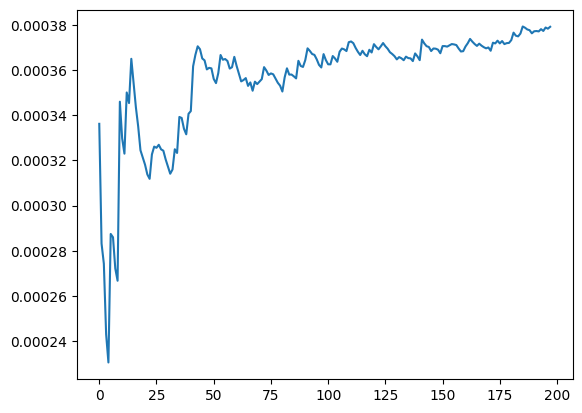

In [160]:
#plt.plot(V)
# variance converging, but increasing? 
# maybe it just looks this way for that one example

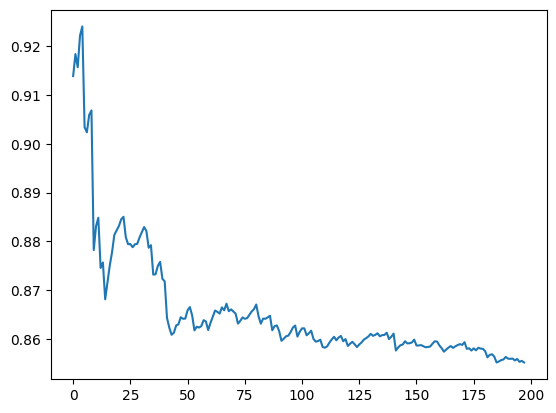

In [171]:
plt.plot(S)

In [ ]:
# TODO: add a CI lower bound to account for # images used for summary

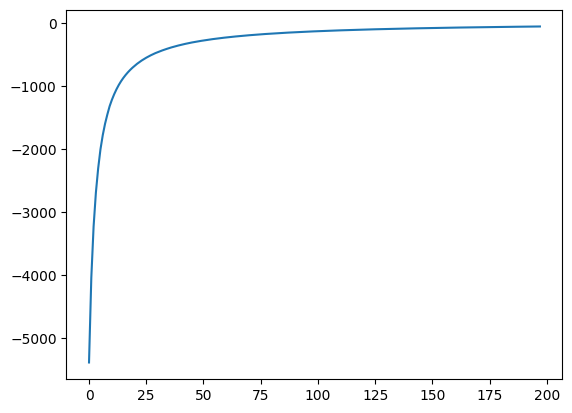

In [176]:
#plt.plot(D) # well, at least it's pretty. too smooth. sus af.

In [58]:
# 1. iterate over folders
# 2. compute summary for prompt
# 3. rank prompts by summary statistic
# 4. bin ranges, plot a few samples in each range

from copy import deepcopy

prompt_diversity = {}
embeds_cache = {}
similarities_cache = {}
for fpath in Path('images').rglob('*'):
    if not fpath.is_dir():
        continue
    if 'full_frame' not in str(fpath):
        continue
    outdir = fpath

    embed_paths = list(outdir.glob(f"*{emb_suffix}.npy"))

    # constrain attention to names we have some threshold number of images for
    if not len(embed_paths) >= 64:
        continue
    
    embeds = []
    for fpath in embed_paths:
        embed = np.load(fpath)
        # normalize
        embed /= np.linalg.norm(embed)
        embeds.append(embed)

        
        
#     S = []
#     for i in range(3, len(embeds)+1):
#         x = np.concatenate(embeds[:i])

#         # centroid similarity
#         mu = x.mean(0)
#         similarities = x@mu
#         S.append(similarities.mean())
    x = np.concatenate(embeds)
    mu = x.mean(0)
    distances = x@mu
    similarities = 1 - distances
    diversity_score = similarities.mean()
    #print(outdir)
    #print((diversity_score, len(embeds)))
    prompt_diversity[str(outdir)] = diversity_score
    embeds_cache[str(outdir)] = deepcopy(embeds)
    similarities_cache[str(outdir)] = deepcopy(similarities)

In [25]:
# vits
from collections import Counter
Counter(prompt_diversity).most_common()

[('images/a_photo_of_rihanna_portrait_photography_full_color_face_full_frame',
  0.22005573),
 ('images/a_photo_of_keanu_portrait_photography_full_color_face_full_frame',
  0.20777254),
 ('images/a_photo_of_madonna_portrait_photography_full_color_face_full_frame',
  0.19391754),
 ('images/a_photo_of_amita_portrait_photography_full_color_face_full_frame',
  0.19353315),
 ('images/a_photo_of_kanye_portrait_photography_full_color_face_full_frame',
  0.18097404),
 ('images/a_photo_of_yuvraj_portrait_photography_full_color_face_full_frame',
  0.1781061),
 ('images/a_photo_of_kobe_portrait_photography_full_color_face_full_frame',
  0.17706792),
 ('images/a_photo_of_adele_portrait_photography_full_color_face_full_frame',
  0.17227925),
 ('images/a_photo_of_leonardo_portrait_photography_full_color_face_full_frame',
  0.16870776),
 ('images/a_photo_of_sung_portrait_photography_full_color_face_full_frame',
  0.16730794),
 ('images/a_photo_of_elon_portrait_photography_full_color_face_full_frame',

In [54]:
# vitg
from collections import Counter
Counter(prompt_diversity).most_common()

[('images/a_photo_of_dalip_portrait_photography_full_color_face_full_frame',
  0.15013313),
 ('images/a_photo_of_kanye_portrait_photography_full_color_face_full_frame',
  0.14998396),
 ('images/a_photo_of_amita_portrait_photography_full_color_face_full_frame',
  0.14608908),
 ('images/a_photo_of_yuvraj_portrait_photography_full_color_face_full_frame',
  0.14344633),
 ('images/a_photo_of_leonardo_portrait_photography_full_color_face_full_frame',
  0.14291014),
 ('images/a_photo_of_rihanna_portrait_photography_full_color_face_full_frame',
  0.14220959),
 ('images/a_photo_of_himesh_portrait_photography_full_color_face_full_frame',
  0.14185078),
 ('images/a_photo_of_pat_portrait_photography_full_color_face_full_frame',
  0.14009741),
 ('images/a_photo_of_kunal_portrait_photography_full_color_face_full_frame',
  0.13774687),
 ('images/a_photo_of_naga_portrait_photography_full_color_face_full_frame',
  0.1366212),
 ('images/a_photo_of_amol_portrait_photography_full_color_face_full_frame',
 

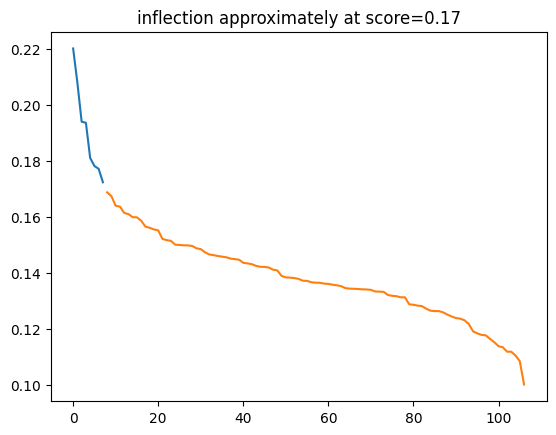

In [45]:
# vits
scores = [v for k,v in Counter(prompt_diversity).most_common()]
scores = np.array(scores)
xv = np.arange(len(scores))
thresh = 0.17
plt.plot(xv[scores>thresh], scores[scores>thresh]) # inflection point score==0.17
plt.plot(xv[scores<=thresh], scores[scores<=thresh])
plt.title(f"inflection approximately at score={thresh}")
plt.show()

seems like a reasonable cutoff from the plot and spot checking the associated names, but a very conspicuous miss is `elon`, which has me concerned this isn't a sufficient measure for distinguishing strong identities (of which "elon" certainly qualifies).

Ditto `Oprah`, `Lebron`. 

I suspect I could improve results some by generating more images, but what I've generated already should be sufficient to differentiate identies. 

Another small "cheat" could be to drop outliers before computing the summary statistics. That's def way easier than generating a bunch of images. 

Another approach could be to try training a bias-focusing encoder, following through on the "identity-preserving contrastive loss" idea. 

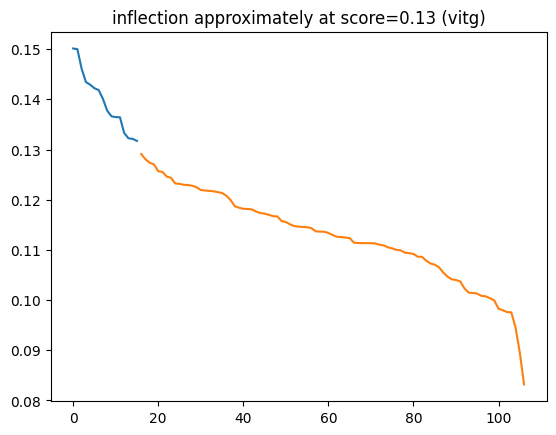

In [56]:
scores = [v for k,v in Counter(prompt_diversity).most_common()]
scores = np.array(scores)
xv = np.arange(len(scores))
thresh = 0.13
plt.plot(xv[scores>thresh], scores[scores>thresh]) # inflection point score==0.17
plt.plot(xv[scores<=thresh], scores[scores<=thresh])
plt.title(f"inflection approximately at score={thresh} (vitg)")
plt.show()

larger capacity of vitg has more "supplementary" information that isn't communicating attributes relevant to identity representation, cluster similarity less effective. either need more images or "bias crystallization" with an encoder. try to learn a reduced rank representation from DINO that only preserves the information salient to differentiating identities.

# Data Exploration Sandbox

Fuck it. tSNE.

In [114]:
# load embeddings

#embeds_cache
#similarities_cache

#embeds = []
inclass_similarities = []
classes = []
for i, score_i in enumerate(similarities_cache.values()):
    inclass_similarities.extend(score_i)
    classes.extend([i]*len(score_i))

len(inclass_similarities), len(classes), len(set(classes))


# collect
# reduce dimension
# plot 2d
# plot 3d (what widget?)


(7801, 7801, 107)

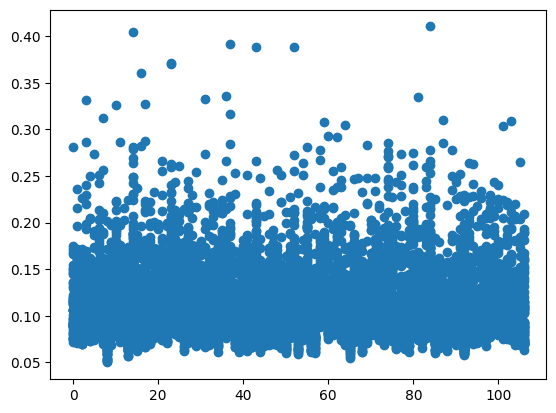

In [78]:
# to do: sort these by class mean
plt.scatter(classes, embeds)


In [79]:
embeds = []
classes = []
for i, embeds_i in enumerate(embeds_cache.values()):
    embeds.extend(embeds_i)
    classes.extend([i]*len(embeds_i))

len(embeds), len(classes), len(set(classes))

(7801, 7801, 107)

In [84]:
embeds = np.array([e.ravel() for e in embeds])

In [85]:
embeds.shape

(7801, 1536)

In [87]:
# fuck it, let's learn an SVM. 
# see which embeddings are more "identity preserving"

import sklearn
from sklearn import svm

# lol... maybe i should use rapids 
# or figure out how to leverage gpu w sklearn

#discriminator = sklearn.svm.SVC()
discriminator = svm.SVC()
discriminator.fit(embeds, arr_classes.ravel())

SVC()

In [88]:
dir(discriminator)

['C',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_proba',
 '_class_weight',
 '_compute_kernel',
 '_decision_function',
 '_dense_decision_function',
 '_dense_fit',
 '_dense_predict',
 '_dense_predict_proba',
 '_dual_coef_',
 '_estimator_type',
 '_gamma',
 '_get_coef',
 '_get_param_names',
 '_get_tags',
 '_impl',
 '_intercept_',
 '_more_tags',
 '_n_support',
 '_num_iter',
 '_parameter_constraints',
 '_probA',
 '_probB',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sparse',
 '_sparse_decision_function',
 '_

In [ ]:
# https://stackoverflow.com/a/41601281/819544
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

#features_names = ['input1', 'input2']
#svm = svm.SVC(kernel='linear')
#svm.fit(X, Y)
f_importances(svm.coef_, features_names)

# lol... what was even the point of this. 2hi4this
# let's just torch it, who am i kidding. i want an encoder.

In [90]:
embeds.shape

(7801, 1536)

In [112]:
# oh right, i still haven't even tsne'd it.

import sklearn.manifold
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd


tsne = TSNE(
    n_components=2
    ,learning_rate='auto'
    ,init='random'
    ,perplexity= 15 # 3 # 40 
    ,n_iter=500 # 3000
)
x_tsne = tsne.fit_transform(embeds)

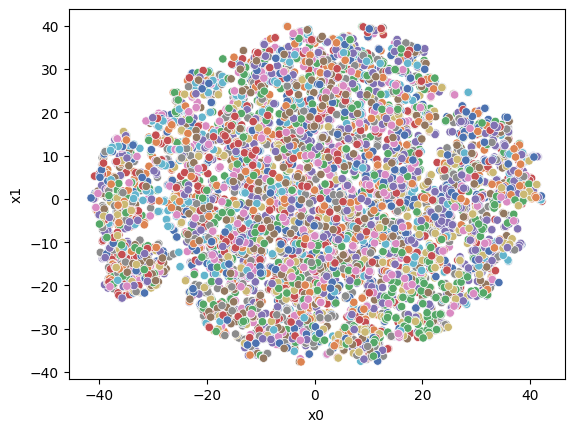

In [118]:

df = pd.DataFrame(
    {
        'x0':x_tsne[:,0], 
        'x1':x_tsne[:,1], 
        'class_id':classes,
        'prior-adherence':inclass_similarities,
    })
sns.scatterplot(
    df, 
    x='x0', 
    y='x1', 
    hue='class_id', 
    #alpha='prior-adherence',
    palette="deep")
ax=plt.gca()
ax.get_legend().remove()
plt.show()

# TODO: use per-class summary score as hue for all points in that class


In [ ]:
# https://umap.scikit-tda.org/supervised.html#using-labels-to-separate-classes-supervised-umap

In [121]:
import umap

In [122]:
%%time
umap_nn20 = umap.UMAP(n_neighbors=20)
umap_embeds_nn20 = umap_nn20.fit_transform(embeds, y=classes)

/home/dmarx/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 1min 35s, sys: 2.17 s, total: 1min 38s
Wall time: 18.2 s


In [123]:
umap_embeds_nn20.shape

(7801, 2)

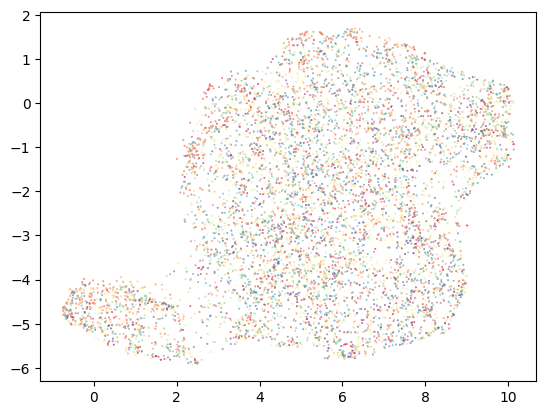

In [124]:
plt.scatter(
    *umap_embeds_nn20.T,
    s=0.1, 
    c=classes,
    cmap='Spectral',
    alpha=1.0)
plt.show()

# TODO

* [ ] filtter out images with more than one face in them (check and report on what gets pulled out)
* [x] calibrate # images for experiments
  * "power analysis" - how many images do we need to detect the variance threshold we're interested in?"
  * going with 64 as a rough ultra-lower bound for now.
* [x] DINOv2 embeddings
  * got it configured for the smallest model, let's try using the largest my card will tolerate.
  * [x] smallest model
  * [ ] largest model
* [ ] image dataloader
* [ ] embeddings dataloader
* [ ] CLIP embeddings
* [ ] unCLIP embeddings
* [ ] upload datasets to HF
  * https://huggingface.co/docs/datasets/upload_dataset
  * [ ] images
  * [ ] small DINO embeds
  * [ ] large DINO embeds
* [x] per-prompt (cluster) summary statistics
* [ ] identity-preserving contrastive encoder
* Visualizations
  * [x] tSNE embeds
  * [ ] tSNE-> 1st PC vs. Diversity Score
  * [ ] Nomic Embedding Atlas
  * [ ] supervised-umap
    * https://umap.scikit-tda.org/supervised.html#using-labels-to-separate-classes-supervised-umap
    * https://umap.scikit-tda.org/supervised.html#training-with-labels-and-embedding-unlabelled-test-data-metric-learning-with-umap
* [ ] separately generate and save input clip emberddings of prompts
* [ ] score images relative to centroid in addition to summary statistic for cluster
  * need a better cluster summary statistic first
* [ ] repeat procedure across several checkpoints, compare per-cluster summary statistics across checkpoints. expect to observe narrowing of biases as checkpoints are progressively finetuned.